In [ ]:
!pip install numpy==1.23.5
!pip install --no-cache-dir pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.2 MB/s eta 0:00:00


=== Data Summary ===
Time Range: 2023-01-01 10:07:00 to 2024-01-01 22:46:00
Total Bars: 6
Unique Products: 16


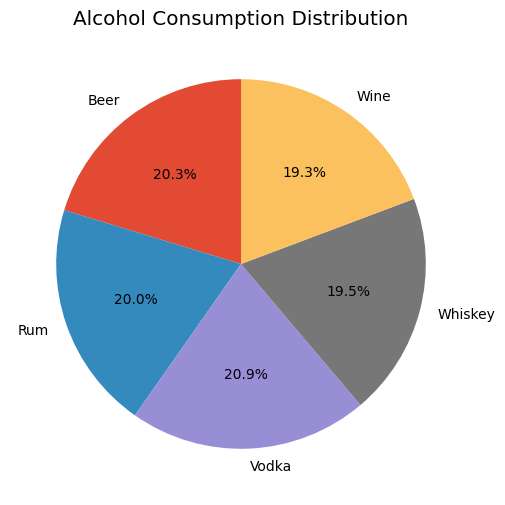


Starting parallel processing for 96 items...
Completed item 1/96: Anderson's Bar | Beer | Budweiser
Completed item 2/96: Anderson's Bar | Beer | Coors
Completed item 3/96: Anderson's Bar | Beer | Miller
Completed item 4/96: Anderson's Bar | Beer | Heineken
Completed item 5/96: Anderson's Bar | Rum | Bacardi
Completed item 6/96: Anderson's Bar | Rum | Malibu
Completed item 7/96: Anderson's Bar | Rum | Captain Morgan
Completed item 8/96: Anderson's Bar | Vodka | Absolut
Completed item 9/96: Anderson's Bar | Vodka | Grey Goose
Completed item 10/96: Anderson's Bar | Vodka | Smirnoff
Completed item 11/96: Anderson's Bar | Whiskey | Jameson
Completed item 12/96: Anderson's Bar | Whiskey | Jack Daniels
Completed item 13/96: Anderson's Bar | Whiskey | Jim Beam
Completed item 14/96: Anderson's Bar | Wine | Barefoot
Completed item 15/96: Anderson's Bar | Wine | Sutter Home
Completed item 16/96: Anderson's Bar | Wine | Yellow Tail
Completed item 17/96: Brown's Bar | Beer | Budweiser
Completed it

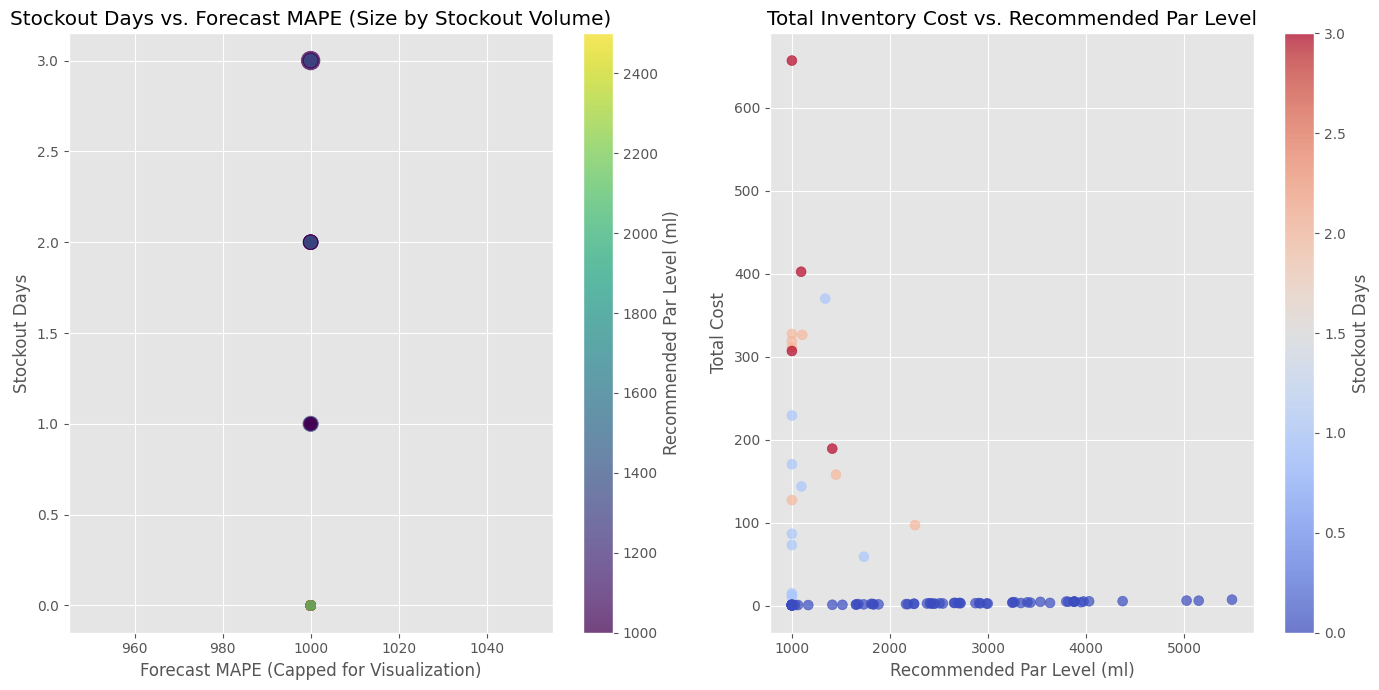

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
import os
import concurrent.futures

warnings.filterwarnings("ignore")

plt.style.use('ggplot')
np.random.seed(42)

# ---
# Configuration Parameters
# ---
FORECAST_HORIZON = 14
LEAD_TIME = 7
SERVICE_LEVEL = 0.95
MIN_PAR_LEVEL_ML = 1000

HOLDING_COST_PER_ML_PER_DAY = 0.0001
STOCKOUT_COST_PER_ML = 0.5

# For handling intermittent demand (many zero consumption days)
ZERO_DEMAND_THRESHOLD = 0.7
# Limits for ARIMA model complexity to speed up fitting
MAX_ARIMA_ORDER = 3
MAX_SEASONAL_ORDER = 1
# Multiplier for the historical window used when calculating forecast errors
ERROR_EVAL_WINDOW_MULTIPLIER = 1

# ---
# 1. Data Pipeline
# ---

class DataProcessor:
    def __init__(self, file_path):
        self.raw_df = pd.read_excel(file_path)
        self.processed_df = None

    def explore_data(self):
        print("=== Data Summary ===")
        print(f"Time Range: {self.raw_df['Date Time Served'].min()} to {self.raw_df['Date Time Served'].max()}")
        print(f"Total Bars: {self.raw_df['Bar Name'].nunique()}")
        print(f"Unique Products: {self.raw_df['Brand Name'].nunique()}")

        # Ensure 'Date Time Served' is a datetime object
        if not pd.api.types.is_datetime64_any_dtype(self.raw_df['Date Time Served']):
            self.raw_df['Date Time Served'] = pd.to_datetime(self.raw_df['Date Time Served'])

        plt.figure(figsize=(8, 6))
        consumption_by_type = self.raw_df.groupby('Alcohol Type')['Consumed (ml)'].sum()
        if not consumption_by_type.empty:
            consumption_by_type.plot.pie(autopct='%1.1f%%', startangle=90)
            plt.title('Alcohol Consumption Distribution')
            plt.ylabel('')
            plt.show()
        else:
            print("No consumption data to plot for alcohol types.")

    def preprocess_data(self):
        df = self.raw_df.copy()
        df['Consumed (ml)'] = df['Consumed (ml)'].fillna(0)
        df['Date Time Served'] = pd.to_datetime(df['Date Time Served'])

        # Capping outliers using IQR method to manage extreme values without removal
        q1 = df['Consumed (ml)'].quantile(0.25)
        q3 = df['Consumed (ml)'].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        lower_bound = q1 - 1.5 * iqr

        df['Consumed (ml)'] = np.where(df['Consumed (ml)'] > upper_bound, upper_bound, df['Consumed (ml)'])
        df['Consumed (ml)'] = np.where(df['Consumed (ml)'] < lower_bound, lower_bound, df['Consumed (ml)'])
        df['Consumed (ml)'] = df['Consumed (ml)'].clip(lower=0)

        # Aggregate data to daily consumption for each unique item at each bar
        daily_df = df.groupby([
            pd.Grouper(key='Date Time Served', freq='D'),
            'Bar Name',
            'Alcohol Type',
            'Brand Name'
        ])['Consumed (ml)'].sum().reset_index()

        # Fill in any missing dates for each unique product-bar combination with zero consumption.
        # This is essential for time series models that expect continuous data.
        filled_groups = []
        for group_keys, group_df in daily_df.groupby(['Bar Name', 'Alcohol Type', 'Brand Name']):
            group_df = group_df.set_index('Date Time Served')
            full_range = pd.date_range(group_df.index.min(), group_df.index.max(), freq='D')
            group_df = group_df.reindex(full_range, fill_value=0)
            group_df['Bar Name'] = group_keys[0]
            group_df['Alcohol Type'] = group_keys[1]
            group_df['Brand Name'] = group_keys[2]
            group_df = group_df.rename_axis('Date Time Served').reset_index()
            filled_groups.append(group_df)

        self.processed_df = pd.concat(filled_groups, ignore_index=True)
        return self.processed_df

# ---
# 2. Forecasting Engine
# ---

class DemandForecaster:
    def __init__(self):
        self.model = None

    def fit_and_forecast(self, train_data, horizon=FORECAST_HORIZON, item_info=""):
        # Handle cases where there's no historical demand data
        if train_data.empty or train_data.sum() == 0:
            return pd.Series(0, index=pd.date_range(train_data.index.max() + pd.Timedelta(days=1), periods=horizon))

        # Check for intermittent demand: if a high percentage of data points are zero,
        # fall back to a simpler average forecast instead of a complex ARIMA model.
        zero_percentage = (train_data == 0).sum() / len(train_data)
        if zero_percentage >= ZERO_DEMAND_THRESHOLD:
            avg_demand = train_data.tail(7).mean()
            forecast_index = pd.date_range(train_data.index.max() + pd.Timedelta(days=1), periods=horizon)
            return pd.Series(avg_demand, index=forecast_index).clip(lower=0)

        try:
            # Set seasonal period (m_val) to 7 if there's enough data for at least two full weeks,
            # otherwise set it to 1 to disable seasonality.
            m_val = 7 if len(train_data) >= 2 * 7 else 1
            self.model = pm.auto_arima(
                train_data,
                start_p=0, start_q=0,
                max_p=MAX_ARIMA_ORDER, max_q=MAX_ARIMA_ORDER,
                m=m_val,
                seasonal=True,
                d=None, D=None,
                max_P=MAX_SEASONAL_ORDER, max_Q=MAX_SEASONAL_ORDER,
                trace=False,
                error_action='ignore',
                suppress_warnings=True,
                stepwise=True
            )
            forecast_values = self.model.predict(n_periods=horizon)
            forecast_index = pd.date_range(train_data.index.max() + pd.Timedelta(days=1), periods=horizon)
            return pd.Series(forecast_values, index=forecast_index).clip(lower=0)
        except Exception as e:
            # If the ARIMA model fails for any reason, use a simple 7-day average as a fallback.
            avg_demand = train_data.tail(7).mean()
            forecast_index = pd.date_range(train_data.index.max() + pd.Timedelta(days=1), periods=horizon)
            return pd.Series(avg_demand, index=forecast_index).clip(lower=0)

    def evaluate_forecast_accuracy(self, actuals, forecast):
        rmse = np.sqrt(mean_squared_error(actuals.values, forecast.values))
        mape = mean_absolute_percentage_error(actuals.values, forecast.values)
        return rmse, mape

    def plot_forecast(self, actuals, forecast, title="Demand Forecast vs Actuals"):
        plt.figure(figsize=(12, 6))
        actuals.plot(label='Historical Demand')
        forecast.plot(label='Forecast')
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Consumption (ml)')
        plt.legend()
        plt.grid(True)
        plt.show()

# ---
# 3. Inventory Optimization
# ---

class InventoryManager:
    def __init__(self, service_level=SERVICE_LEVEL):
        self.service_level = service_level
        # Calculate the Z-score corresponding to the desired service level (e.g., 95% service level).
        self.z_score = norm.ppf(service_level)

    def calculate_par_level(self, forecasted_demand_sum, forecast_errors_std, current_stock_ml, lead_time_days=LEAD_TIME):
        # Safety stock calculation based on forecast error standard deviation and lead time.
        safety_stock = self.z_score * forecast_errors_std * np.sqrt(lead_time_days)
        par_level = forecasted_demand_sum + safety_stock
        par_level = max(par_level, MIN_PAR_LEVEL_ML)

        return par_level

    def calculate_costs(self, daily_holding_cost_per_ml, stockout_cost_per_ml,
                        avg_inventory, total_stockout_ml):
        total_holding_cost = avg_inventory * daily_holding_cost_per_ml
        total_stockout_cost = total_stockout_ml * stockout_cost_per_ml
        return total_holding_cost, total_stockout_cost

# ---
# 4. Simulation Engine
# ---

class InventorySimulator:
    def __init__(self, initial_stock_ml, par_level_ml, lead_time_days=LEAD_TIME):
        self.inventory = initial_stock_ml
        self.par_level = par_level_ml
        self.lead_time = lead_time_days
        self.stockouts_count = 0
        self.overstock_count = 0
        self.total_stockout_volume_ml = 0
        self.inventory_history = []
        self.order_pending = 0
        self.days_until_arrival = 0

    def simulate_day(self, consumption_ml):
        self.inventory_history.append(self.inventory)

        self.inventory -= consumption_ml

        # If inventory goes negative, it means a stockout occurred.
        if self.inventory < 0:
            self.total_stockout_volume_ml += abs(self.inventory)
            self.stockouts_count += 1
            self.inventory = 0

        # Check for overstock conditions based on a threshold relative to the par level.
        if self.inventory > self.par_level * 1.2:
            self.overstock_count += 1

        # Decrement days until an pending order arrives.
        if self.days_until_arrival > 0:
            self.days_until_arrival -= 1
        # If an order is due today, add it to inventory.
        if self.days_until_arrival == 0 and self.order_pending > 0:
            self.inventory += self.order_pending
            self.order_pending = 0

        # Implement a simple periodic review replenishment logic:
        # If inventory falls below a certain threshold and no order is currently pending, place a new order.
        if self.inventory < self.par_level * 0.2 and self.order_pending == 0:
            # Order up to the par level, also compensating for any past stockouts.
            order_quantity = self.par_level - self.inventory + self.total_stockout_volume_ml
            if order_quantity > 0:
                self.order_pending = order_quantity
                self.days_until_arrival = self.lead_time

        return self.inventory

    def get_simulation_report(self):
        avg_inventory = np.mean(self.inventory_history) if self.inventory_history else 0
        return {
            'Final Inventory (ml)': round(self.inventory, 2),
            'Stockout Days': self.stockouts_count,
            'Total Stockout Volume (ml)': round(self.total_stockout_volume_ml, 2),
            'Overstock Days': self.overstock_count,
            'Average Inventory (ml)': round(avg_inventory, 2),
            'Total Holding Cost': round(avg_inventory * HOLDING_COST_PER_ML_PER_DAY * len(self.inventory_history), 2),
            'Total Stockout Cost': round(self.total_stockout_volume_ml * STOCKOUT_COST_PER_ML, 2)
        }

# ---
# 5. Main Execution Pipeline (Parallelized)
# ---

# Function to process a single item (bar-alcohol-brand combination).
# Designed to be run in parallel for efficiency.
def process_single_item(group_keys, group_df, min_data_points_for_analysis):
    bar, alcohol, brand = group_keys
    item_info = f"{bar} | {alcohol} | {brand}"

    ts = group_df.set_index('Date Time Served')['Consumed (ml)'].asfreq('D', fill_value=0)

    # Skip analysis for items with insufficient historical data.
    if len(ts) < min_data_points_for_analysis:
        return None

    # Split the time series into training data for forecasting and a test set for simulation.
    train_end_idx = len(ts) - FORECAST_HORIZON
    train = ts.iloc[:train_end_idx]
    test = ts.iloc[train_end_idx:]

    # Calculate forecast for the combined horizon needed for par level (forecast + lead time).
    forecaster = DemandForecaster()
    forecast_horizon_for_par_calc = FORECAST_HORIZON + LEAD_TIME
    forecast_for_par_calc = forecaster.fit_and_forecast(train, horizon=forecast_horizon_for_par_calc, item_info=item_info)

    actuals_for_error = []
    predictions_for_error = []
    forecast_errors = []

    # Perform a rolling (walk-forward) validation on a subset of the historical data
    # to get a robust estimate of forecast errors.
    error_evaluation_start_idx = max(0, len(ts) - (ERROR_EVAL_WINDOW_MULTIPLIER * FORECAST_HORIZON))
    evaluation_data = ts.iloc[error_evaluation_start_idx:]

    if len(evaluation_data) < FORECAST_HORIZON + 7:
        forecast_errors_std = train.std() if not train.empty else 0
    else:
        for i in range(len(evaluation_data) - FORECAST_HORIZON):
            current_train = evaluation_data.iloc[:i + FORECAST_HORIZON]
            current_test_period = evaluation_data.iloc[i + FORECAST_HORIZON : i + FORECAST_HORIZON + 1]

            if not current_test_period.empty and not current_train.empty:
                daily_forecast = forecaster.fit_and_forecast(current_train, horizon=1, item_info=item_info)
                if not daily_forecast.empty:
                    actuals_for_error.append(current_test_period.iloc[0])
                    predictions_for_error.append(daily_forecast.iloc[0])
                    forecast_errors.append(current_test_period.iloc[0] - daily_forecast.iloc[0])

        if len(forecast_errors) > 5:
            forecast_errors_std = pd.Series(forecast_errors).std()
        else:
            forecast_errors_std = train.std() if not train.empty else 0

    # Handle cases where standard deviation might be zero to prevent division errors.
    if forecast_errors_std == 0:
        forecast_errors_std = train.std() if not train.empty else 10

    # Calculate overall RMSE and MAPE for the item based on the rolling validation.
    if len(actuals_for_error) > 0 and len(predictions_for_error) > 0:
        rmse, mape = forecaster.evaluate_forecast_accuracy(
            pd.Series(actuals_for_error), pd.Series(predictions_for_error)
        )
    else:
        rmse, mape = np.nan, np.nan

    manager = InventoryManager(service_level=SERVICE_LEVEL)
    # Calculate the recommended par level using the forecasted demand and estimated forecast errors.
    par_level = manager.calculate_par_level(
        forecasted_demand_sum=forecast_for_par_calc.sum(),
        forecast_errors_std=forecast_errors_std,
        current_stock_ml=train.iloc[-1] if not train.empty else 0
    )
    simulator = InventorySimulator(
        initial_stock_ml=par_level,
        par_level_ml=par_level,
        lead_time_days=LEAD_TIME
    )
    # Run the simulation for the item using the 'test' demand data.
    for day_consumption in test.values:
        simulator.simulate_day(day_consumption)

    sim_report = simulator.get_simulation_report()

    return {
        'Bar Name': bar,
        'Brand Name': brand,
        'Alcohol Type': alcohol,
        'Recommended Par Level (ml)': round(par_level, 2),
        **sim_report,
        'Forecast RMSE': round(rmse, 2),
        'Forecast MAPE': round(mape, 3)
    }


if __name__ == "__main__":
    data_file_path = '/content/Consumption Dataset.xlsx'
    processor = DataProcessor(data_file_path)
    processor.explore_data()
    clean_data = processor.preprocess_data()

    results = []

    # Calculate the minimum number of data points an item needs to be included in the analysis.
    MIN_DATA_POINTS_FOR_ANALYSIS = FORECAST_HORIZON + LEAD_TIME + ERROR_EVAL_WINDOW_MULTIPLIER * FORECAST_HORIZON

    all_groups_list = list(clean_data.groupby(['Bar Name', 'Alcohol Type', 'Brand Name']))
    total_items = len(all_groups_list)

    print(f"\nStarting parallel processing for {total_items} items...")

    # Use a ProcessPoolExecutor to run the analysis for each item in parallel,
    # utilizing all available CPU cores.
    with concurrent.futures.ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
        # Submit tasks and create a mapping from future objects back to the group keys.
        futures = {executor.submit(process_single_item, group_keys, group_df, MIN_DATA_POINTS_FOR_ANALYSIS): group_keys
                   for group_keys, group_df in all_groups_list}

        # Iterate over the completed tasks as they finish, providing real-time feedback.
        for i, future in enumerate(concurrent.futures.as_completed(futures)):
            group_keys = futures[future]
            item_info = f"{group_keys[0]} | {group_keys[1]} | {group_keys[2]}"
            try:
                result = future.result()
                if result:
                    results.append(result)
                print(f"Completed item {i+1}/{total_items}: {item_info}")
            except Exception as exc:
                print(f'Item {item_info} generated an exception: {exc}')

    # ---
    # 6. Final Reporting and Visualization
    # ---

    results_df = pd.DataFrame(results)
    if not results_df.empty:
        print("\n=== Final Recommendations and Simulation Results ===")
        print(results_df[[
            'Bar Name', 'Brand Name', 'Recommended Par Level (ml)',
            'Stockout Days', 'Total Stockout Volume (ml)', 'Overstock Days',
            'Total Holding Cost', 'Total Stockout Cost',
            'Forecast RMSE', 'Forecast MAPE'
        ]].sort_values(by='Stockout Days', ascending=False))

        plt.figure(figsize=(14, 7))

        plt.subplot(1, 2, 1)
        # Handle infinite or NaN MAPE values for plotting, capping extremely large ones.
        results_df['Plot_MAPE'] = results_df['Forecast MAPE'].replace([np.inf, -np.inf], np.nan).fillna(results_df['Forecast MAPE'].max())
        large_mape_cap = 1000
        results_df['Plot_MAPE'] = results_df['Plot_MAPE'].apply(lambda x: min(x, large_mape_cap) if pd.notna(x) else large_mape_cap)

        scatter1 = plt.scatter(
            results_df['Plot_MAPE'], results_df['Stockout Days'],
            c=results_df['Recommended Par Level (ml)'], cmap='viridis', s=results_df['Total Stockout Volume (ml)']/10 + 50, alpha=0.7, vmin=1000, vmax=2500
        )
        plt.colorbar(scatter1, label='Recommended Par Level (ml)')
        plt.title('Stockout Days vs. Forecast MAPE (Size by Stockout Volume)')
        plt.xlabel('Forecast MAPE (Capped for Visualization)')
        plt.ylabel('Stockout Days')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        results_df['Total Cost'] = results_df['Total Holding Cost'] + results_df['Total Stockout Cost']
        scatter2 = plt.scatter(
            results_df['Recommended Par Level (ml)'], results_df['Total Cost'],
            c=results_df['Stockout Days'], cmap='coolwarm', s=50, alpha=0.7
        )
        plt.colorbar(scatter2, label='Stockout Days')
        plt.title('Total Inventory Cost vs. Recommended Par Level')
        plt.xlabel('Recommended Par Level (ml)')
        plt.ylabel('Total Cost')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    else:
        print("\nNo sufficient data to generate recommendations.")